# Goal of Analysis:

## Help the company XYZ to analyze and identify the information from their URL and answer the questions posted

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings 
warnings.filterwarnings('ignore')

## Question 1:

Create a clean data set where each column is a ﬁeld in the URL, each row is a given search and the cells are the corresponding URL values.

In [2]:
with open('url_list.txt') as f:
    lines = f.readlines()
    
print('Total Records:\t', len(lines))

Total Records:	 77677


In [3]:
def parse_search(lines):
    """ function to parse user's search history """
    length = len(lines)
    names = ['checkin', 'checkout', 'customMinimumPriceFilter', 
             'customMaximumPriceFilter', 'freeCancellation', 'stars_5', 
             'stars_4', 'stars_3', 'stars_2', 'stars_1', 'max_score', 
             'min_score', 'couponCode', 'adults', 'city', 'children', 
             'amenities', 'search_page']
    
    maps = {}
    for name in names:
        maps[name] = [np.nan] * length
      
    for i in range(length):
        line = lines[i]
        items = line[50:].strip().split('&')
        visited = set()
        for item in items:
            key, value = item.strip().split('=')
            key = key.strip().split('.')[1]
            if key == 'city':
                value = value.strip().replace('+', ' ')
            if key not in visited:
                maps[key][i] = value
                visited.add(key)
            else:
                maps[key][i] = maps[key][i] + ', ' + value
            
    # transform into DataFrame
    df = pd.DataFrame(maps, columns=names)
    df['checkin'] = pd.to_datetime(df['checkin'])
    df['checkout'] = pd.to_datetime(df['checkout'])
    df = df.rename(columns={'customMinimumPriceFilter': 'MinPrice', 
                            'customMaximumPriceFilter': 'MaxPrice'})
    
    return df

In [4]:
# parse all the data
data = parse_search(lines)
data.head()

,checkin,checkout,MinPrice,MaxPrice,freeCancellation,stars_5,stars_4,stars_3,stars_2,stars_1,max_score,min_score,couponCode,adults,city,children,amenities,search_page
0,2015-09-19,2015-09-20,NaN,NaN,NaN,NaN,yes,NaN,NaN,NaN,NaN,4,NaN,3,"New York, NY, United States",NaN,NaN,1
1,2015-09-14,2015-09-15,NaN,NaN,NaN,NaN,NaN,yes,NaN,NaN,NaN,4,NaN,3,"London, United Kingdom",NaN,NaN,1
2,2015-09-26,2015-09-27,NaN,175,NaN,NaN,yes,NaN,NaN,NaN,NaN,5,NaN,2,"New York, NY, United States",NaN,NaN,1
3,2015-09-02,2015-09-03,NaN,NaN,NaN,yes,yes,NaN,NaN,NaN,NaN,4,NaN,1,"Hong Kong, Hong Kong",NaN,NaN,1
4,2015-09-20,2015-09-29,NaN,275,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,NaN,3,"London, United Kingdom",NaN,NaN,1


# Question 2:

For each search query, how many amenities were selected?

In [5]:
# let's first take a look at how many amenities are there

data['amenities'].value_counts()

internet                272
yes_smoking             170
shuttle                 111
yes_pet                  85
breakfast                39
lounge                   22
yes_smoking, yes_pet      4
breakfast, yes_pet        1
Name: amenities, dtype: int64

In [6]:
# let's now check number of amenities for each search query

data['amenities'].apply(lambda x: 0 if pd.isnull(x) else len(x.split(', '))).value_counts()

0    76973
1      699
2        5
Name: amenities, dtype: int64

# Question 3:

Often, to measure the quality of a search algorithm, data scientists use some metric based on how often users click on the second page, third page, and so on. The idea here is that a great search algorithm should return all interesting results on the ﬁrst page and never force users to visit the other pages (how often do you click on the second page results when you search on Google? Almost never, right?).

Create a metric based on the above idea and ﬁnd the city with the worst search algorithm.

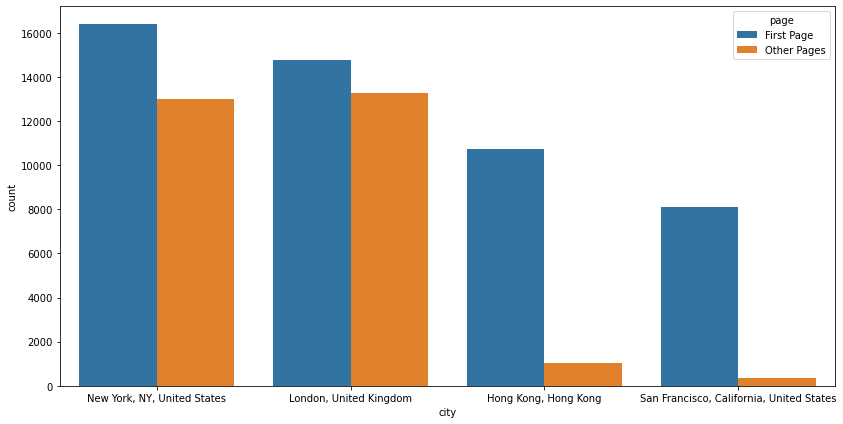

In [7]:
data['page'] = data['search_page'].apply(lambda x: 'First Page' if x == '1' else 'Other Pages')

fig, ax = plt.subplots(figsize=(12, 6))
sns.countplot(x='city', hue='page', data=data, ax=ax)
plt.tight_layout()
plt.show()

As we can see, all of the cities will just click on the first page, some cities have a higher number of clicking the second pages but some of them are not.

In [8]:
grouped = data.groupby(['city', 'page'])['checkin'].count().unstack()
grouped['ratio'] = grouped['Other Pages'] / (grouped['First Page'] + grouped['Other Pages'])

grouped

page,First Page,Other Pages,ratio
city,,,
"Hong Kong, Hong Kong",10735,1051,0.089174
"London, United Kingdom",14775,13283,0.473412
"New York, NY, United States",16385,12999,0.442384
"San Francisco, California, United States",8105,344,0.040715


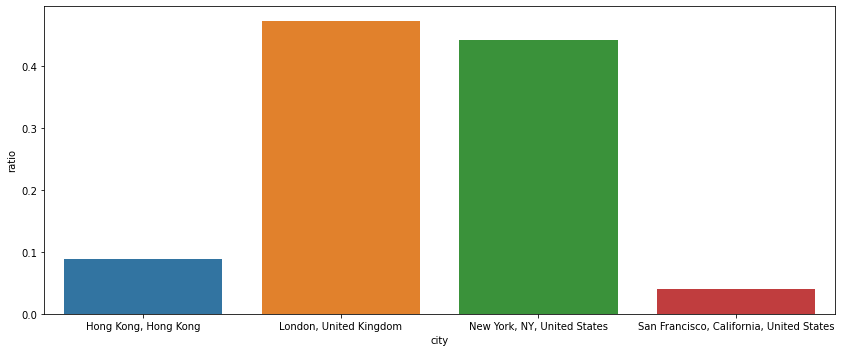

In [9]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(x=grouped.index, y='ratio', data=grouped, ax=ax)
plt.tight_layout()
plt.show()

If we use the ratio of other pages versus total visits, we can see that London and New York have pretty high ratio. It's clear that London and New York have pretty bad search algorithms.